<b> Predict Sales  
    Data Description: </b>
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge. Then:

1. for the list of shops and products I should then create a data frame that can be extended with the new lists.
2. target feature —> total amount of a given product sold in a given shop per month
3. item_cnt_day (# of product sold in a given day)
Then I should create a column item_cnt_month

<b> Features: </b>  
ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,…, October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category  

<a id='table_of_contents'></a>

0. [Import Packages](#imports_packages)  
1. [Import Data](#imports_data)
2. [Data Exploration](#data_exploration)
3. [Data Cleaning](#data_cleaning)
4. [Data Preparation](#data_preparation)
5. [Feature Engineering](#feature_engineering)
6. [Benchmark Modelling](#benchmark_modelling)
7. [Evaluation of the Model](#evaluating_model)


# 0. Import Packages <a id='imports_packages'></a>
[Back to top](#table_of_contents)

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Data <a id='imports_data'></a>
[Back to top](#table_of_contents)

In [105]:
item_categories = pd.read_csv('Data/item_categories.csv')
#item_categories.head()


# 2. Data Exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

### Item Categories

In [106]:
item_categories['item_category_name'].nunique()

84

In [107]:
item_categories['item_category_name'].apply(lambda x: print(x) if 'Аксессуары' in x else False )

Аксессуары - PS2
Аксессуары - PS3
Аксессуары - PS4
Аксессуары - PSP
Аксессуары - PSVita
Аксессуары - XBOX 360
Аксессуары - XBOX ONE
Игры - Аксессуары для игр


0     False
1      None
2      None
3      None
4      None
      ...  
79    False
80    False
81    False
82    False
83    False
Name: item_category_name, Length: 84, dtype: object

* There are 84 item categories.

### Item List 

In [108]:
item_list = pd.read_csv('Data/items.csv')
item_list.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


array([[<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_category_id'}>]], dtype=object)

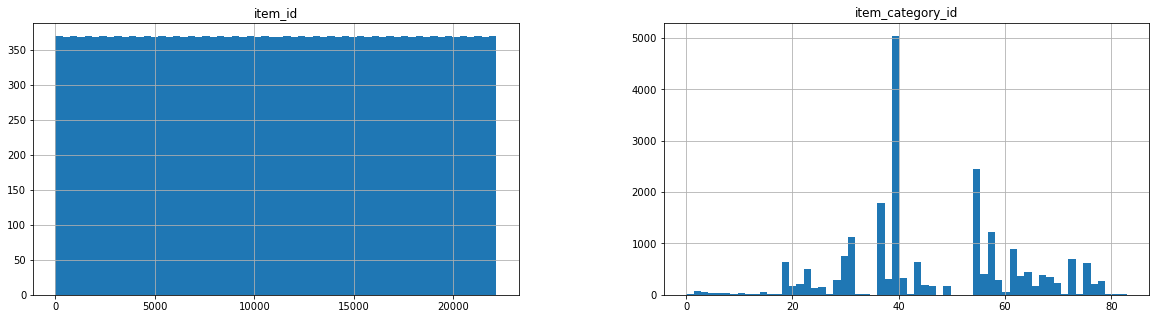

In [109]:
item_list.hist(figsize=(20,5), bins=60)

In [110]:
print(item_list['item_id'].nunique(), 'unique items')

22170 unique items


In [111]:
item_list['item_category_id'].value_counts()

40    5035
55    2365
37    1780
31    1125
58     790
      ... 
50       2
1        2
10       1
51       1
79       1
Name: item_category_id, Length: 84, dtype: int64

In [112]:
for i in 40, 55, 37, 31:
    print(item_categories[item_categories['item_category_id']==i].item_category_name)

40    Кино - DVD
Name: item_category_name, dtype: object
55    Музыка - CD локального производства
Name: item_category_name, dtype: object
37    Кино - Blu-Ray
Name: item_category_name, dtype: object
31    Игры PC - Цифра
Name: item_category_name, dtype: object


* There are 22170 different items in the store and the features of them --> item_id, item_category_id
* Most of the items belong to item_category #40 which is "Кино - DVD"

In [113]:
item_id_list = item_list[['item_id', 'item_category_id']]

In [114]:
item_id_list.dtypes

item_id             int64
item_category_id    int64
dtype: object

### Shops

In [115]:
shops = pd.read_csv('Data/shops.csv')
shops.columns
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [116]:
def add_city_feature(data):
    data.loc[data['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
    data['city'] = data['shop_name'].str.split(" ").map(lambda x: x[0])
    data.loc[data['city'] == '!Якутск', 'city'] = 'Якутск'
    data['city_id'] = data['city'].factorize()[0]
    return data

In [117]:
shops_info = add_city_feature(shops)

In [118]:
shops_info.head()

,shop_name,shop_id,city,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3


* There are 60 shops and their IDs are listed. There are duplicates which are:

In [119]:
print(shops_info['shop_name'][57], shops_info['shop_name'][0])
print(shops_info['shop_name'][58], shops_info['shop_name'][1])
print(shops_info['shop_name'][10], shops_info['shop_name'][11])

Якутск Орджоникидзе, 56 !Якутск Орджоникидзе, 56 фран
Якутск ТЦ "Центральный" !Якутск ТЦ "Центральный" фран
Жуковский ул. Чкалова 39м? Жуковский ул. Чкалова 39м²


In [120]:
shops_cleaned = shops_info.copy()
shops_cleaned = shops_cleaned.drop([0, 1, 11]).reset_index()

In [121]:
shops_cleaned.city.value_counts()
#shops_cleaned.city_id.plot(kind='hist', y='city', x=shops_cleaned.city, figsize=(10,5))
#plt.xticks(label=shops_cleaned.city)

#fig, ax = plt.subplots(figsize=(10,5))
#ax.hist(shops_cleaned.city, bins=40)
#ax.set_xticks(bins)
#ax.set_xticklabels(dir='vertical')

Москва              13
РостовНаДону         3
Воронеж              3
Тюмень               3
Новосибирск          2
Казань               2
Н.Новгород           2
Якутск               2
Уфа                  2
СПб                  2
Самара               2
Красноярск           2
Выездная             1
Ярославль            1
Мытищи               1
СергиевПосад         1
Интернет-магазин     1
Омск                 1
Сургут               1
Цифровой             1
Волжский             1
Жуковский            1
Балашиха             1
Коломна              1
Адыгея               1
Химки                1
Курск                1
Вологда              1
Калуга               1
Чехов                1
Томск                1
Name: city, dtype: int64

In [122]:
print(shops_cleaned.shape)
shops_cleaned.city.nunique()

(57, 5)


31

There are 57 unique shops and 31 unique cities. The most of the shops (13/57) are in Москва. 

### Sample Submission

A sample submission file in the correct format. Like a hint?

In [123]:
sample_sub = pd.read_csv('Data/sample_submission.csv')
sample_sub.head(2)

,ID,item_cnt_month
0,0,0.5
1,1,0.5


### Training Set

The training set. Daily historical data from January 2013 to October 2015.

In [124]:
sales_train = pd.read_csv('Data/sales_train.csv')
sales_train.head(3)
#sales_train[sales_train['shop_id']==0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [125]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

We should convert the types from object to date_time.

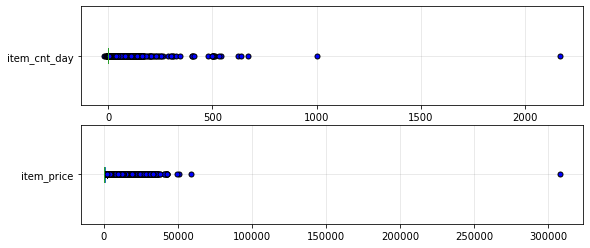

In [126]:

flierprops = dict(marker='o', markerfacecolor='blue', markersize=5, markeredgecolor='black')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[9, 4])
sales_train.plot.box(ax=axes[0], x='item_id', y='item_cnt_day', flierprops=flierprops, vert=False)
sales_train.plot.box(ax=axes[1], x='item_id', y='item_price', flierprops=flierprops, vert=False)

ax = plt.gca()
#axes[0].set_xlabel('days')
#axes[1].set_xlabel('price')
axes[0].grid(axis='both', color='gray', alpha=.2)
axes[1].grid(axis='both', color='gray', alpha=.2)
plt.show()


* There are negative price and days in addition to outliers. We should remove them.

In [127]:
len(sales_train[sales_train['item_cnt_day']<0])

7356

* There are 7356 negative item_cnt_day (# of product counts cannot be negative. However, could -1 mean product return? )

* What is the currency? Do these number make sense? Which products cost the mosts?

In [128]:
#sales_train_sorted_on_price = sales_train.sort_values('item_price', ascending=False)

In [129]:
sales_train.loc[sales_train.item_price.idxmax()]

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price          307980.0
item_cnt_day             1.0
Name: 1163158, dtype: object

In [130]:
print(item_list[item_list['item_id']==6066])
print(shops[shops['shop_id']==12])

                 item_name  item_id  item_category_id
6066  Radmin 3  - 522 лиц.     6066                75
              shop_name  shop_id              city  city_id
12  Интернет-магазин ЧС       12  Интернет-магазин        8


I googled it and saw that Radmin 3  - 522 лиц is a remote control software.20 dollars  
Only one shop sells this product. 
307980 russian ruble is 4381.04 USD in October 2021. Thus, the price listed for this product may be unreal. Considering that we do not have any other sample for this product, we may thinking about removing this item from the list. However, I will keep for now.

In [131]:
sales_train['item_id'].nunique()

21807

There were 22k item types sold. However, there are 21k of them in the training set.

### Testing Set

The test set. You need to forecast the sales for these shops and products for November 2015.

In [132]:
sales_test = pd.read_csv('Data/test.csv')
print(sales_test.shape)
sales_test.head(2)

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [133]:
sales_test.isna().sum()
#sales_train.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [134]:
sales_test.dtypes

ID         int64
shop_id    int64
item_id    int64
dtype: object

In [135]:
#sales_test['shop_id'].nunique()

In [136]:
sales_test['item_id'].value_counts()

2049     42
6743     42
13266    42
21342    42
17244    42
         ..
7338     42
1193     42
3240     42
13359    42
2047     42
Name: item_id, Length: 5100, dtype: int64

Each item type appears 42 times in the test_data. 5100/22170 item types are represented in the test set.

# 3. Data Cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

1. Removing duplicates
2. Negative item_cnt_day  
3. Negative item prices  
4. Outlier prices and cnt_days

In [137]:
sales_train.loc[sales_train.shop_id==0, 'shop_id'] = 57
sales_train.loc[sales_train.shop_id==1, 'shop_id'] = 58
sales_train.loc[sales_train.shop_id==10, 'shop_id'] = 11

sales_test.loc[sales_test.shop_id==0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id==1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id==10, 'shop_id'] = 11

In [138]:
sales_train_cleaned = sales_train.copy()
len(sales_train_cleaned[(sales_train_cleaned['item_cnt_day']<0)])

7356

7356 is not a significant amount of data points to remove given the size of the whole dataset. Thus, I prefer removing them.

In [139]:
print(sales_train_cleaned.shape)
sales_train_cleaned = sales_train_cleaned[(sales_train_cleaned['item_cnt_day']>0)]
print(sales_train_cleaned.shape)

(2935849, 6)
(2928493, 6)


In [140]:
sales_train_cleaned = sales_train_cleaned[(sales_train_cleaned['item_price']>0) & (sales_train_cleaned['item_price']<100000)]
print(sales_train_cleaned.shape)

(2928491, 6)


In [141]:
sales_train_cleaned.sort_values('item_price', ascending=False).head(7)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0
2327159,29.01.2015,24,12,7241,49782.0,1.0
2910156,29.10.2015,33,12,13403,42990.0,1.0
2931380,20.10.2015,33,22,13403,42990.0,1.0
2917760,20.10.2015,33,3,13403,42990.0,1.0
2885692,23.10.2015,33,42,13403,42990.0,1.0


In [142]:
item_list[item_list['item_id']==13199] #made up a number

,item_name,item_id,item_category_id
13199,Коллекционные шахматы (Властелин Колец),13199,69


This is a Lord of the Rings Chess Set. In 2021, it costs 731 USD which makes this datapoint a meaningful one.

# 4. Data Preparation<a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [143]:
sales_train_prepared = sales_train_cleaned.copy()

In [144]:
sales_train_prepared.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

Let's convert the date into datetime.

In [145]:
sales_train_prepared['date'] = pd.to_datetime(sales_train_prepared['date'], dayfirst=True)

sales_train_prepared['salesYear'] = sales_train_prepared['date'].dt.year
sales_train_prepared['salesMonth'] = sales_train_prepared['date'].dt.month
sales_train_prepared['salesDay'] = sales_train_prepared['date'].dt.day
sales_train_prepared.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,salesYear,salesMonth,salesDay
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15
5,2013-01-10,0,25,2564,349.00,1.0,2013,1,10


In [146]:
#item_id_list = item_list[['item_id', 'item_category_id']]
sales_train_prepared = sales_train_prepared.merge(item_id_list, left_on='item_id', right_on='item_id', how='left')
sales_train_prepared = sales_train_prepared.merge(shops_info[['shop_id', 'city', 'city_id']], left_on='shop_id', right_on='shop_id', how='left')

sales_train_prepared.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,salesYear,salesMonth,salesDay,item_category_id,city,city_id
0,2013-01-02,0,59,22154,999.0,1.0,2013,1,2,37,Ярославль,30
1,2013-01-03,0,25,2552,899.0,1.0,2013,1,3,58,Москва,14


item_id, shop_id, city_id_ item_category_id, date_block_num are not numerical values since item_id 5 is not bigger than item_id 3 or so on. I will convert them into strings.

In [147]:
#sales_train_prepared.loc[:, 'item_id'] = sales_train_prepared['item_id'].astype(str)
#sales_train_prepared.loc[:, 'item_category_id'] = sales_train_prepared['item_category_id'].astype(str)
#sales_train_prepared.loc[:, 'date_block_num'] = sales_train_prepared['date_block_num'].astype(str)
#sales_train_prepared.loc[:, 'shop_id'] = sales_train_prepared['shop_id'].astype(str)

In [148]:
sales_train_grouped_by_year = sales_train_prepared.groupby(['salesYear']).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'total_cnt_year'}, inplace=False).reset_index()
sales_train_grouped_by_year.head(2)

,salesYear,total_cnt_year
0,2013,1565895.0
1,2014,1323594.0


In [149]:
sales_train_grouped_by_month = sales_train_prepared.groupby(['salesYear', 'salesMonth']).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'total_cnt_month'}, inplace=False).reset_index()
sales_train_grouped_by_month.head(2)

,salesYear,salesMonth,total_cnt_month
0,2013,1,131850.0
1,2013,2,128382.0


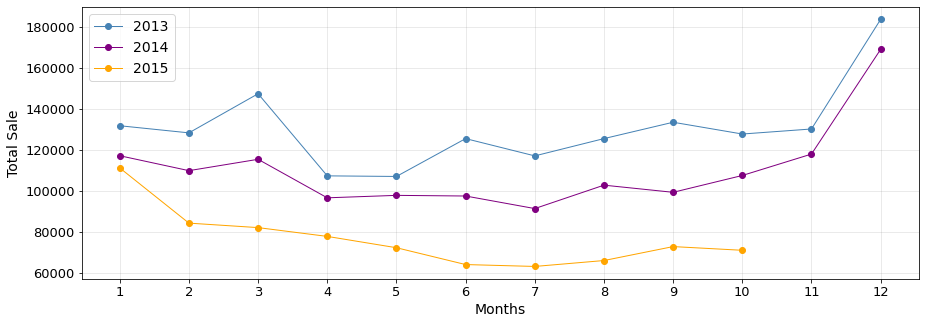

In [150]:
plt.figure(figsize=(15,5))
# Plot the sales of the year 2013
plt.plot(sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2013]['salesMonth'], sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2013]['total_cnt_month'], '-o', color='steelblue', linewidth=1, label='2013')
plt.plot(sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2014]['salesMonth'], sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2014]['total_cnt_month'], '-o', color='purple', linewidth=1, label='2014')
plt.plot(sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2015]['salesMonth'], sales_train_grouped_by_month[sales_train_grouped_by_month['salesYear']==2015]['total_cnt_month'], '-o', color='orange', linewidth=1, label='2015')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Total Sale', fontsize=14)

ax = plt.gca()
ax.grid(axis='both', color='gray', alpha=.2)
#ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_ticks(np.arange(1, 13, 1))
plt.show()

In [153]:
sales_train_prepared.loc[:,'item_cnt_day'] = sales_train_prepared['item_cnt_day'].astype(int)
sales_train_prepared.dtypes

date                datetime64[ns]
date_block_num               int64
shop_id                      int64
item_id                      int64
item_price                 float64
item_cnt_day                 int64
salesYear                    int64
salesMonth                   int64
salesDay                     int64
item_category_id             int64
city                        object
city_id                      int64
dtype: object

In [154]:
sales_train_grouped_by_item = sales_train_prepared.groupby(['salesYear', 'item_id']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_year'})
print(sales_train_grouped_by_item.shape)
#sales_train_grouped_by_item.loc[:,'item_id'] = sales_train_grouped_by_item['item_id'].astype(str)
sales_items_2013 = sales_train_grouped_by_item[sales_train_grouped_by_item['salesYear']==2013].sort_values('total_cnt_year', ascending=False).reset_index()
sales_items_2014 = sales_train_grouped_by_item[sales_train_grouped_by_item['salesYear']==2014].sort_values('total_cnt_year', ascending=False).reset_index()
sales_items_2015 = sales_train_grouped_by_item[sales_train_grouped_by_item['salesYear']==2015].sort_values('total_cnt_year', ascending=False).reset_index()

sales_train_grouped_by_item.head(2)

(40317, 3)


,salesYear,item_id,total_cnt_year
0,2013,12,1
1,2013,19,1


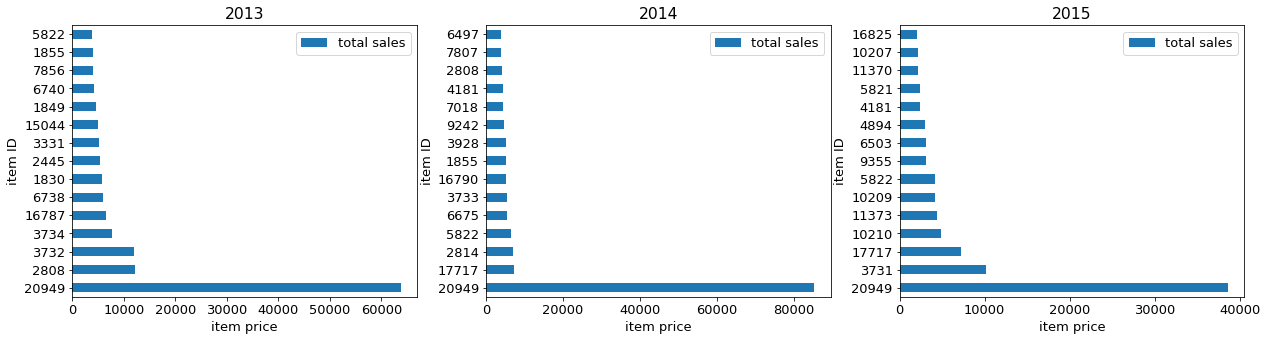

In [155]:
plt.rcParams.update({'font.size': 13}) # must set in top

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[21, 5])

sales_items_2013[0:15].plot(ax=axes[0], x='item_id', y='total_cnt_year', kind='barh', title='2013', label = 'total sales')
sales_items_2014[0:15].plot(ax=axes[1], x='item_id', y='total_cnt_year', kind='barh', title='2014', label = 'total sales')
sales_items_2015[0:15].plot(ax=axes[2], x='item_id', y='total_cnt_year', kind='barh', title='2015', label = 'total sales')

for i in (0,1,2):
    axes[i].set_ylabel('item ID')
    axes[i].set_xlabel('item price')

<b> Plotting # of product sold per category during Jan 2013-Oct 2015: item_category_id vs item_cnt_day </b>

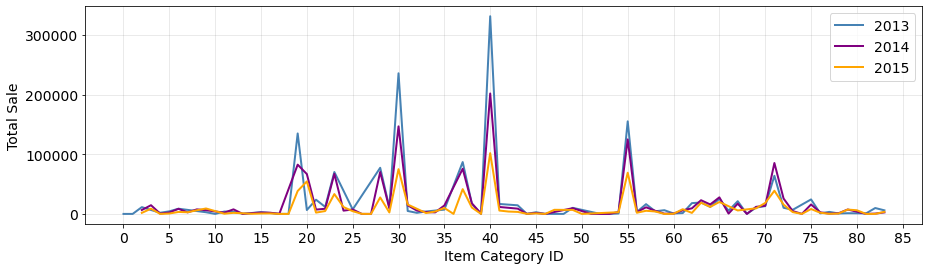

In [156]:
#sales_train_grouped_by_category.loc[:, 'item_category_id']=sales_train_grouped_by_category['item_category_id'].astype(int)
plt.rcParams.update({'font.size': 14}) # must set in top

sales_train_grouped_by_category = sales_train_prepared.groupby(['item_category_id', 'salesYear']).agg({'item_cnt_day': 'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt'})
sales_train_grouped_by_category = sales_train_grouped_by_category.sort_values('item_category_id')
#sales_train_grouped_by_category.reset_index().plot(y='total_cnt', x='item_category_id', kind='line', figsize=(20,5), xlabel='category ID', ylabel='total sales', fontsize=14)

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2013]['item_category_id'], sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2013]['total_cnt'], color='steelblue', linewidth=2, label='2013')
plt.plot(sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2014]['item_category_id'], sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2014]['total_cnt'], color='purple', linewidth=2, label='2014')
plt.plot(sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2015]['item_category_id'], sales_train_grouped_by_category[sales_train_grouped_by_category['salesYear']==2015]['total_cnt'], color='orange', linewidth=2, label='2015')

ax = plt.gca()
ax.set_xlabel('Item Category ID')
ax.set_ylabel('Total Sale')
ax.legend()
ax.grid(axis='both', color='gray', alpha=.2)
ax.xaxis.set_ticks(np.arange(0, 90, 5))

plt.show()


<b> Plotting # of products sold over the months and the years: date_block_num vs item_cnt_day </b>

<AxesSubplot:xlabel='date_block_num'>

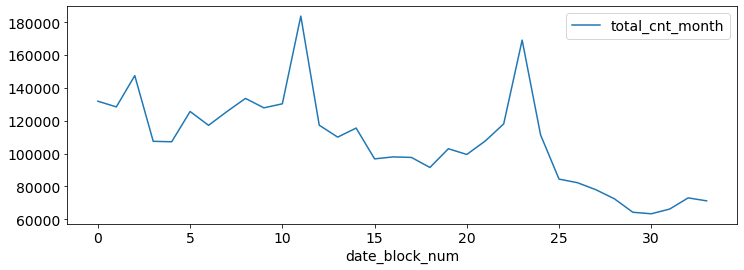

In [157]:
sales_train_grouped_by_block = sales_train_prepared.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_month'})
sales_train_grouped_by_block.columns
sales_train_grouped_by_block.plot(y='total_cnt_month', x='date_block_num', figsize=(12,4))

In [158]:
#check
#a= sales_train_prepared[sales_train_prepared['date_block_num']==0]['item_cnt_day'].sum()
#print(a)
#b= sales_train_prepared[sales_train_prepared['date_block_num']==1]['item_cnt_day'].sum()
#print(b)
#sales_train_grouped_by_block.head(2)

The general trend is a decrease in the sales over time even though there are sharp increases and decreases.

In [159]:
sales_test_prepared = sales_test.merge(item_id_list, left_on='item_id', right_on='item_id', how='left')
sales_test_prepared = sales_test_prepared.merge(shops_info[['shop_id', 'city', 'city_id']], left_on='shop_id', right_on='shop_id', how='left')

sales_test_prepared.head(2) 

,ID,shop_id,item_id,item_category_id,city,city_id
0,0,5,5037,19,Вологда,4
1,1,5,5320,55,Вологда,4


In [160]:
sales_test_prepared = sales_test_prepared.drop('ID', axis=1)
sales_test_prepared.head(1)

,shop_id,item_id,item_category_id,city,city_id
0,5,5037,19,Вологда,4


The aim is to predict the sales for the items and shops given in test set for November 2015. Thus, we should add a column named 'date_block_num' to test set and set all the values in this column to 34.

In [161]:
sales_test_prepared['date_block_num'] = 34
sales_test_prepared['salesYear'] = 2015
sales_test_prepared['salesMonth'] = 11
print(sales_train_prepared.shape)
sales_test_prepared.head(2)

(2928491, 12)


,shop_id,item_id,item_category_id,city,city_id,date_block_num,salesYear,salesMonth
0,5,5037,19,Вологда,4,34,2015,11
1,5,5320,55,Вологда,4,34,2015,11


In [162]:
#sales_test_prepared.loc[:,'shop_id'] = sales_test_prepared['shop_id'].astype(str)
#sales_test_prepared.loc[:,'item_id'] = sales_test_prepared['item_id'].astype(str)
#sales_test_prepared.loc[:,'city_id'] = sales_test_prepared['city_id'].astype(str)
#sales_test_prepared.loc[:,'item_category_id'] = sales_test_prepared['item_category_id'].astype(str)
#sales_test_prepared.loc[:,'date_block_num'] = sales_test_prepared['date_block_num'].astype(str)

In [163]:
#print(sales_train_prepared.shape)

sales_train_block_summed = sales_train_prepared.groupby(['item_id', 'shop_id', 'date_block_num']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'total_cnt_month'})
sales_train_grouped_by_item[sales_train_grouped_by_item['item_id']==16787]

sales_train_block_summed.head(2)

,item_id,shop_id,date_block_num,total_cnt_month
0,0,54,20,1
1,1,55,15,2


In [164]:
sales_train_block_summed.loc[:,'total_cnt_month'] = sales_train_block_summed['total_cnt_month'].astype(int)

In [165]:
sales_train_block_summed.dtypes

item_id            int64
shop_id            int64
date_block_num     int64
total_cnt_month    int64
dtype: object

In [166]:
sales_train_block_summed.shape

(1608225, 4)

In [167]:
sales_train_block_summed.columns

Index(['item_id', 'shop_id', 'date_block_num', 'total_cnt_month'], dtype='object')

In [168]:
shop_train = sales_train_block_summed['shop_id'].nunique()
shop_test = sales_test_prepared['shop_id'].nunique()
item_train = sales_train_block_summed['item_id'].nunique()
item_test = sales_test_prepared['item_id'].nunique()
all_shop = shops_cleaned['shop_id'].nunique()
all_item = item_list['item_id'].nunique()

print("%d out of %d shops are in test data set and %d out of %d are represented in the training" 
      %(shop_test, all_shop, shop_train, all_shop))

print("%d out of %d items are in test data set and %d out of %d are represented in the training" 
      %(item_test, all_item, item_train, all_item))

42 out of 57 shops are in test data set and 57 out of 57 are represented in the training
5100 out of 22170 items are in test data set and 21803 out of 22170 are represented in the training


It means that sales data for 22170-21803=367 items cannot be predicted.
Also we can think about including only the items that are asked to be predicted in.

In [169]:
test_items = pd.DataFrame(sales_test_prepared['item_id'].unique(), columns={'item_id'})
test_items.loc[:,'item_id']=test_items['item_id'].astype(str)
train_items = sales_train_block_summed['item_id'].unique()
test_items.isin(train_items.tolist()).head(5)
#print(train_items)
test_items['isin_training_set'] = test_items['item_id'].apply(lambda x: True if x in train_items.tolist() else False)
len(test_items)

missing_items = []
test_items['item_id'].apply(lambda x: missing_items.append(x) if not x in train_items.tolist() else True)
len(missing_items)

5100

There are 363 item_ids which are present in test set but not in training set. For these items we cannot expect our model to make good predictions because we dont have any data related to these items to train a model. For now, i will keep them and continue with the benchmark modelling. According to evaluation of the first model, I will decide to remove/keep them.



# 5. Feature Engineering<a id='feature_engineering_'></a>
[Back to top](#table_of_contents)

In [171]:
sales_train_block_summed.dtypes

item_id            int64
shop_id            int64
date_block_num     int64
total_cnt_month    int64
dtype: object

In [172]:
def lag_feature(df, lags, col):
    print(col)
    for i in lags:
        shifted = df[['date_block_num', 'shop_id', 'item_id', col]].copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+"_lag_"+str(i)]
        shifted.date_block_num += i
        df = df.merge(shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
    return df

The part below assumes that whenever there is not any total_cnt_month available for any shop_id-item_id-date_block_num triplet, the sale is zero. According to the this assumption:


There were available stocks, however, the items were not sold. All items were always in the market since before doing fillna('0'), the beginning date of the sale info were not checked.

However, in real life, these items might not be in the market since the beginning or even if they were there might be a stock-related problem and these items cannot be sold again. Putting zero for such a case may cause a mistaken prediction for the future sales as the stocks could be renewed in the future.

In [174]:
from itertools import product

product_matrix = []
total_len = 0
# Try creating a matrix of product(sales['date_block_num'].unique(), sales.shop_id.unique(), sales.item_id.unique()) which are about 45m lines
for num in sales_train_block_summed['date_block_num'].unique():
    tmp = sales_train_block_summed[sales_train_block_summed.date_block_num==num] #
    product_matrix.append(np.array(list(product([num], tmp.shop_id.unique(), tmp.item_id.unique()))))
    #print(product([num], tmp.shop_id.unique(), tmp.item_id.unique()))
    total_len = total_len + (len(tmp.shop_id.unique())*len(tmp.item_id.unique()))
    #matrix.append(np.array(list(product([num], shops.shop_id, items.item_id)), dtype='int16'))
    
print("Size of the feature matrix must be ", total_len, '.')

# Turn the grid into a dataframe
product_matrix = pd.DataFrame(np.vstack(product_matrix), columns=['date_block_num', 'shop_id', 'item_id'])
#print(product_matrix.shape)
product_matrix.dtypes

# Adding total_cnt_month from the sales data to the product matrix:
product_matrix = product_matrix.merge(sales_train_block_summed, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)

# Adding the features of shops, items and item_categories:
product_matrix = product_matrix.merge(shops_cleaned[['shop_id', 'city_id']], how='left', on='shop_id')
product_matrix = product_matrix.merge(item_id_list[['item_id','item_category_id']], how='left', on='item_id')
#product_matrix.loc[:,'city_id'] = product_matrix['city_id'].astype(int)
product_matrix.head(2)

# Add month
product_matrix['month'] = product_matrix.date_block_num%12+1 #i added + 1 because block_num startes from 0 (e.g. Jan 2013 = 0)
product_matrix.dtypes


# If fillna.('NA')instead of fillna('0')
#product_matrix_c = product_matrix.copy()
#print(product_matrix_c.shape)
#def remove_nan_rows(df, col):
#    df = df[df[col]!='NA']
#    return df

#cols = list(product_matrix_c.columns)
#for c in cols:
#    print(c)
#    product_matrix_c = remove_nan_rows(product_matrix_c, str(c))
#
#product_matrix_c.shape

# Clip counts
product_matrix.loc[:,'total_cnt_month'] = product_matrix['total_cnt_month'].astype(int)
product_matrix['total_cnt_month'] = product_matrix['total_cnt_month'].clip(0, 20)

Size of the feature matrix must be  10884508 .


In [175]:
product_matrix = product_matrix[product_matrix['date_block_num']>=12]
product_matrix.reset_index(drop=True, inplace=True)

#lag frames
myframe = product_matrix.copy() #didnt use product_matrix here

#myframe.loc[:,'date_block_num'] = myframe['date_block_num'].astype(int)
lags = [1, 3, 5, 11]

myframe = lag_feature(myframe, lags, 'total_cnt_month')
myframe.dtypes

total_cnt_month


date_block_num              int64
shop_id                     int64
item_id                     int64
total_cnt_month             int64
city_id                   float64
item_category_id            int64
month                       int64
total_cnt_month_lag_1     float64
total_cnt_month_lag_3     float64
total_cnt_month_lag_5     float64
total_cnt_month_lag_11    float64
dtype: object

In [176]:
grouped_myframe = myframe.groupby(['item_id', 'date_block_num']).agg({'total_cnt_month':'sum'}).reset_index().rename(columns={'total_cnt_month':'total_cnt_month_item'})
myframe = myframe.merge(grouped_myframe, on=['item_id', 'date_block_num'], how='left').fillna(0)

myframe =lag_feature(myframe, lags, 'total_cnt_month_item')
myframe = myframe.drop('total_cnt_month_item', axis=1)

grouped_myframe = myframe.groupby(['shop_id', 'date_block_num']).agg({'total_cnt_month':'sum'}).reset_index().rename(columns={'total_cnt_month':'total_cnt_month_shop'})
myframe = myframe.merge(grouped_myframe, on=['shop_id', 'date_block_num'], how='left').fillna(0)

myframe =lag_feature(myframe, lags, 'total_cnt_month_shop')
myframe = myframe.drop('total_cnt_month_shop', axis=1)

myframe.dtypes

total_cnt_month_item
total_cnt_month_shop


date_block_num                   int64
shop_id                          int64
item_id                          int64
total_cnt_month                  int64
city_id                        float64
item_category_id                 int64
month                            int64
total_cnt_month_lag_1          float64
total_cnt_month_lag_3          float64
total_cnt_month_lag_5          float64
total_cnt_month_lag_11         float64
total_cnt_month_item_lag_1     float64
total_cnt_month_item_lag_3     float64
total_cnt_month_item_lag_5     float64
total_cnt_month_item_lag_11    float64
total_cnt_month_shop_lag_1     float64
total_cnt_month_shop_lag_3     float64
total_cnt_month_shop_lag_5     float64
total_cnt_month_shop_lag_11    float64
dtype: object

In [ ]:
no_nan_frame = myframe.copy()
print(no_nan_frame.shape)
def remove_nan_rows(df, col):
    df = df[df[col]!='NaN']
    return df

cols = list(no_nan_frame.columns)
for c in cols:
    print(c)
    no_nan_frame = remove_nan_rows(no_nan_frame, str(c))
    
#print(no_nan_frame.shape)

In [ ]:
#myframe[(myframe['date_block_num']==30) & (myframe['shop_id']=='42') & (myframe['item_id']=='22154')]

In [ ]:
#myframe[(myframe['date_block_num']==29) & (myframe['shop_id']=='42') & (myframe['item_id']=='22154')]

# 6. Benchmark Modelling <a id='benchmark_modelling'></a>
[Back to top](#table_of_contents)

In [ ]:
#target_feature_bm = ['total_cnt_month']
#categorical_features_bm = ['item_id', 'item_category_id', 'shop_id', 'city_id', 'month']
#input_features_bm = categorical_features_bm

In [177]:
dataframe_bm = myframe.copy()

dataframe_bm.loc[:,'shop_id'] = dataframe_bm['shop_id'].astype(str)
dataframe_bm.loc[:,'item_id'] = dataframe_bm['item_id'].astype(str)
dataframe_bm.loc[:,'city_id'] = dataframe_bm['city_id'].astype(str)
dataframe_bm.loc[:,'item_category_id'] = dataframe_bm['item_category_id'].astype(str)
dataframe_bm.loc[:,'month'] = dataframe_bm ['month'].astype(str)


x_train_bm = dataframe_bm[dataframe_bm['date_block_num']<33].drop('total_cnt_month', axis=1)
y_train_bm = dataframe_bm[dataframe_bm['date_block_num']<33]['total_cnt_month']

x_val_bm = dataframe_bm[dataframe_bm['date_block_num']==33].drop('total_cnt_month', axis=1)
y_val_bm = dataframe_bm[dataframe_bm['date_block_num']==33]['total_cnt_month']

x_test_bm = dataframe_bm[dataframe_bm['date_block_num']==34].drop('total_cnt_month', axis=1)
y_test_bm = dataframe_bm[dataframe_bm['date_block_num']==34]['total_cnt_month']

x_train_bm = x_train_bm.drop('date_block_num', axis=1)
x_val_bm = x_val_bm.drop('date_block_num', axis=1)
x_test_bm = x_test_bm.drop('date_block_num', axis=1)

## Decision Tree

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [180]:
y_train_bm.dtypes
#X_train_bm, X_test_bm, Y_train_bm, Y_test_bm = train_test_split(x_train_bm, y_train_bm, test_size = 0.33, random_state = 42)

dtype('int64')

In [98]:
x_train_bm.head(20)

,shop_id,item_id,city_id,item_category_id,month,total_cnt_month_lag_1,total_cnt_month_lag_3,total_cnt_month_lag_5,total_cnt_month_lag_11,total_cnt_month_item_lag_1,total_cnt_month_item_lag_3,total_cnt_month_item_lag_5,total_cnt_month_item_lag_11,total_cnt_month_shop_lag_1,total_cnt_month_shop_lag_3,total_cnt_month_shop_lag_5,total_cnt_month_shop_lag_11
0,54,0,27.0,40,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,54,1,27.0,76,9,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,5448.0,0.0,4630.0,0.0
2,54,4,27.0,40,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54,8,27.0,40,9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5448.0,0.0,0.0,0.0
4,54,13,27.0,40,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,54,16,27.0,40,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,54,17,27.0,40,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,54,21,27.0,40,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,54,30,27.0,40,9,2.0,0.0,1.0,0.0,12.0,13.0,21.0,0.0,5448.0,5427.0,4630.0,0.0
9,54,31,27.0,37,9,1.0,1.0,1.0,0.0,13.0,13.0,21.0,0.0,5448.0,5427.0,4630.0,0.0


In [181]:
tree = DecisionTreeRegressor(max_depth = 8) #tuning hyperparameters and finding the optimal values will be done later.
tree.fit(x_train_bm, y_train_bm)

recent_model = tree
y_pred_bm = recent_model.predict(x_val_bm)

mean_absolute_error =  0.34989714300332087
mean_squared_error =  0.9686526361405678
root_mean_squared_error =  0.9842015221185993
r2 =  0.25099393942411186


<AxesSubplot:>

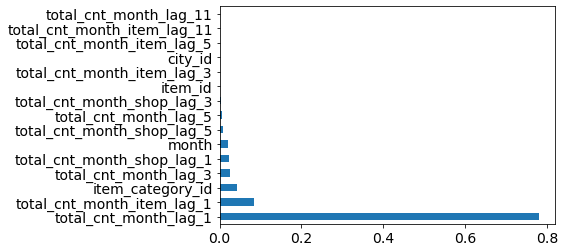

In [183]:
# evaluation metrics          
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error = ',  mean_absolute_error(y_val_bm, y_pred_bm ) )
print('mean_squared_error = ', mean_squared_error(y_val_bm, y_pred_bm))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_val_bm, y_pred_bm)))
print('r2 = ', r2_score(y_val_bm, y_pred_bm))

(pd.Series(tree.feature_importances_, index=x_train_bm.columns)
   .nlargest(15)
   .plot(kind='barh'))

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor 

random_forest_model = RandomForestRegressor(n_estimators= 400,
 min_samples_split= 20,
 min_samples_leaf= 4,
 max_features= 'auto',
 max_depth= 10,
 n_jobs = -1,                                              
 bootstrap= True)
random_forest_model.fit(x_train_bm, y_train_bm)

recent_model = random_forest_model
y_pred_rf = recent_model.predict(x_val_bm)

In [ ]:
# evaluation metrics          
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error = ',  mean_absolute_error(y_val_bm, y_pred_bm ) )
print('mean_squared_error = ', mean_squared_error(y_val_bm, y_pred_bm))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_val_bm, y_pred_bm)))
print('r2 = ', r2_score(y_val_bm, y_pred_bm))

(pd.Series(tree.feature_importances_, index=x_train_bm.columns)
   .nlargest(15)
   .plot(kind='barh'))

## Gradient Boosting

In [ ]:
# evaluation metrics          
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error = ',  mean_absolute_error(y_val_bm, y_pred_rf ) )
print('mean_squared_error = ', mean_squared_error(y_val_bm, y_pred_rf))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_val_bm, y_pred_rf)))
print('r2 = ', r2_score(y_val_bm, y_pred_rf))

(pd.Series(random_forest_model.feature_importances_, index=x_train_bm.columns)
   .nlargest(15)
   .plot(kind='barh'))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

#hyper_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9], 
#                'gamma': [0, 0.5, 1, 1.5, 2, 5], 
#                'subsample': [0.6, 0.7, 0.8, 0.9, 1], 
#                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
#                'learning_rate': [0.01, 0.1, 0.2, 0.3],
#                'max_bin' : [256, 512, 1024]
#               }

#xgbr = XGBRegressor(seed = 13, tree_method = "hist") #gpu_hist

#clf = RandomizedSearchCV(estimator = xgbr, 
#                   param_distributions = hyper_params,
#                   n_iter = 2, #500
#                   scoring = 'neg_root_mean_squared_error',
#                   cv = splits,
#                   verbose=3)

#clf.fit(X_train, y_train)

#print("Best parameters:", clf.best_params_)
#print("Lowest RMSE: ", -clf.best_score_)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoost_model = GradientBoostingRegressor() 
gradientBoost_model.fit(x_train_bm, y_train_bm)

recent_model = gradientBoost_model
y_pred_gb = recent_model.predict(x_test_bm)

In [ ]:
print('mean_absolute_error = ',  mean_absolute_error(y_test_bm, y_pred_gb ) )
print('mean_squared_error = ', mean_squared_error(y_test_bm, y_pred_gb))
print('root_mean_squared_error = ', sqrt(mean_squared_error(y_test_bm, y_pred_gb)))
print('r2 = ', r2_score(y_test_bm, y_pred_gb))

(pd.Series(gradientBoost_model.feature_importances_, index=x_train_bm.columns)
   .nlargest(15)
   .plot(kind='barh'))

In [ ]:
# Maximum numbr of levels in tree
max_depth = [10, 20, 50, 70, 100, 200, 300, 500]
max_depth.append(None)

#The minimum number of samples required to be at a leaf node
min_samples_leaf = [1, 2, 4, 8, 10, 20, 30]

#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30, 40]

#The number of features to consider when looking for the best split
max_features = ['auto', 'sqrt']

#If False, the whole dataset is used to build each tree.
bootstrap = [True, False]

#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

In [ ]:

import pprint as pp

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#uses random_grid to search for the best hyper-parameters

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=5, cv=3, 
                              verbose=2, random_state=42, n_jobs=4)


# Fit the random search model
rf_random.fit(x_train_bm, y_train_bm)
#performances = pd.DataFrame.from_dict(rf_random.cv_results_).to_csv("comparison_performances.csv")
#performances.head()

In [ ]:
performances = pd.DataFrame.from_dict(rf_random.cv_results_).to_csv("comparison_performances.csv")
#performances.head()

In [ ]:
#a = (sales_test_prepared['item_id']=='5320').index[(sales_test_prepared['item_id']=='5320')==True]
#print(a)

#b = []
#say = 0
#for x in missing_items:
#    say = say+1
#    a = (sales_test_prepared['item_id']==str(x)).index[(sales_test_prepared['item_id']==str(x))==True]
#    for i in list(a):
#        b.append(i)
#len(b)

#test_set_prepared_no_missing_items = sales_test_prepared.copy()
#for missing_item_index in b:  
#    test_set_prepared_no_missing_items = test_set_prepared_no_missing_items.drop(missing_item_index, axis=0)

214200-15246

In [ ]:
pd.DataFrame.from_dict(rf_random.cv_results_)